In [21]:
# Instala librerías necesarias
!pip install torch

In [22]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## A - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,3,3,1]

### I - Grilla de 5 x 5:

PINN:

Epoch 0, Loss: 0.8478553891181946
Epoch 1000, Loss: 0.08674474060535431
Epoch 2000, Loss: 0.05257926881313324
Epoch 3000, Loss: 0.008814901113510132
Epoch 4000, Loss: 0.004729229956865311
Epoch 5000, Loss: 0.002812412567436695
Epoch 6000, Loss: 0.0019778169225901365
Epoch 7000, Loss: 0.0007669090991839767
Epoch 8000, Loss: 0.0005003889091312885
Epoch 9000, Loss: 0.0004400621692184359


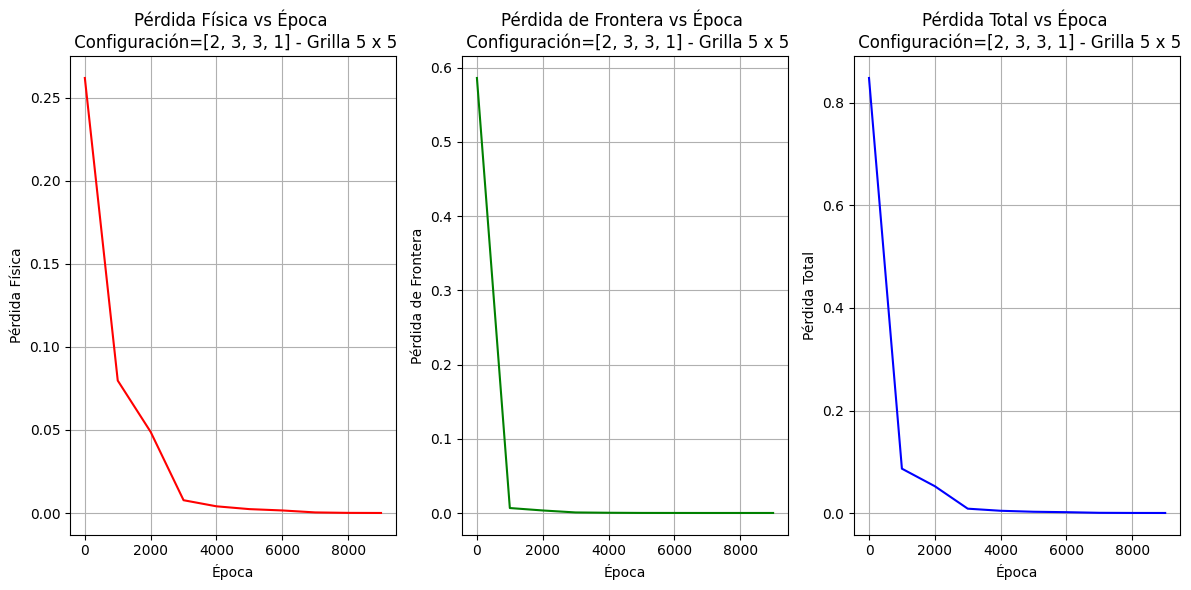

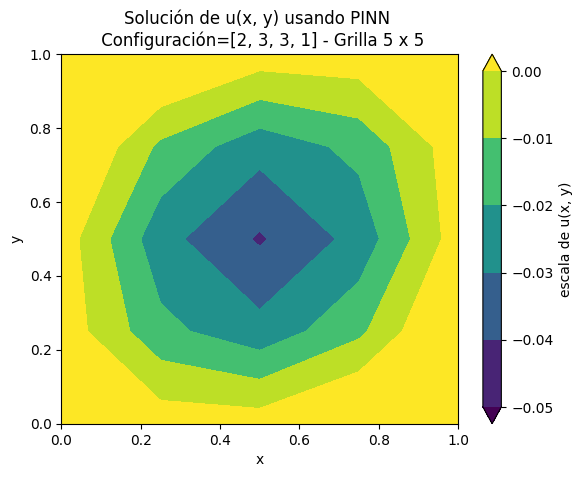

In [23]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada: (x, y), Salida: 3 neuronas
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 5x5)
        x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
        y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 5x5
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_5x5, y_5x5, u_pred_5x5, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

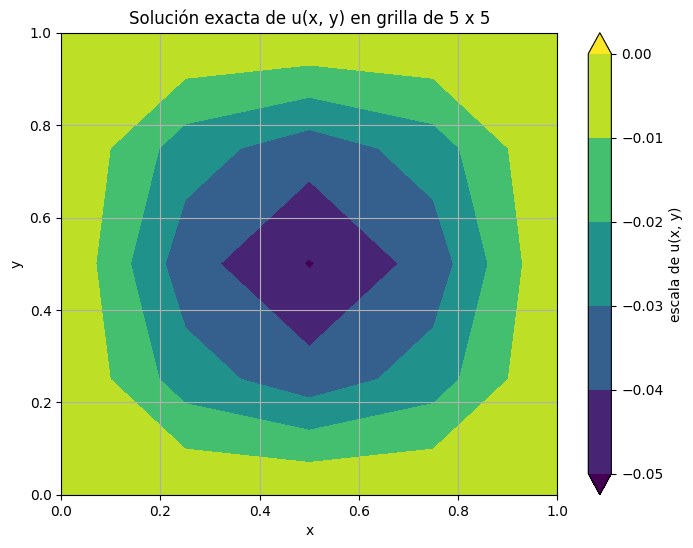

In [24]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_5x5, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

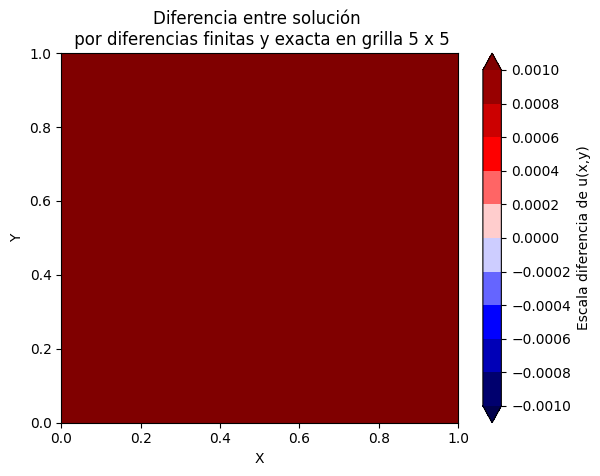

In [25]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_5x5, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.3256600499153137
Epoch 1000, Loss: 0.049650296568870544
Epoch 2000, Loss: 0.01110834814608097
Epoch 3000, Loss: 0.006684653460979462
Epoch 4000, Loss: 0.00589107908308506
Epoch 5000, Loss: 0.004625567235052586
Epoch 6000, Loss: 0.002462327014654875
Epoch 7000, Loss: 0.00201637065038085
Epoch 8000, Loss: 0.001401251065544784
Epoch 9000, Loss: 0.0008461395627819002


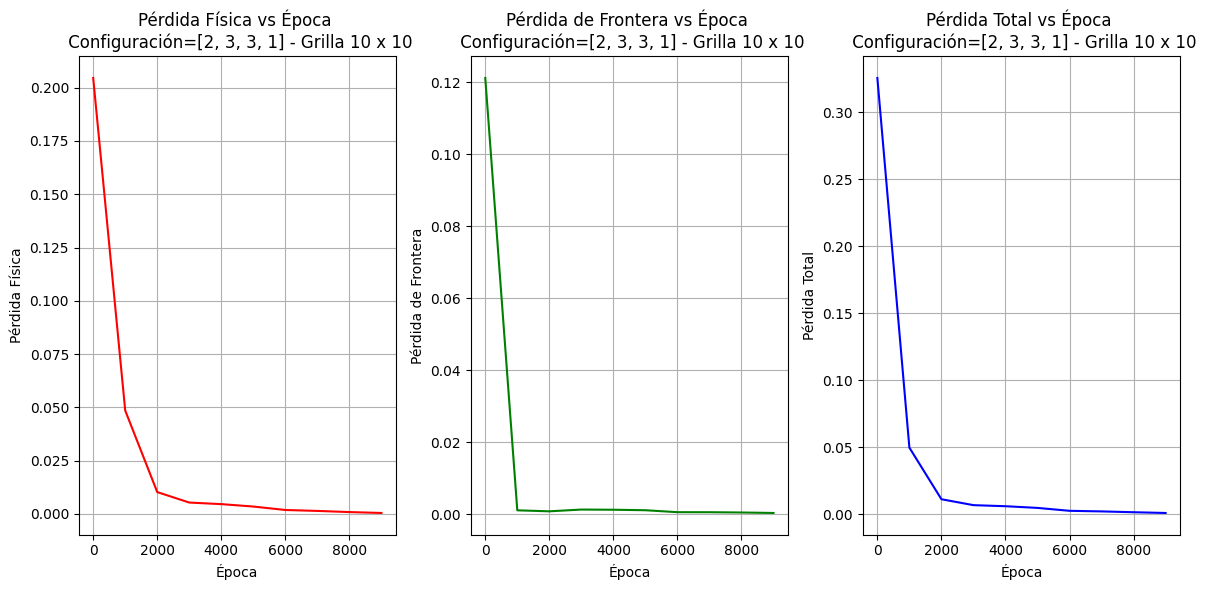

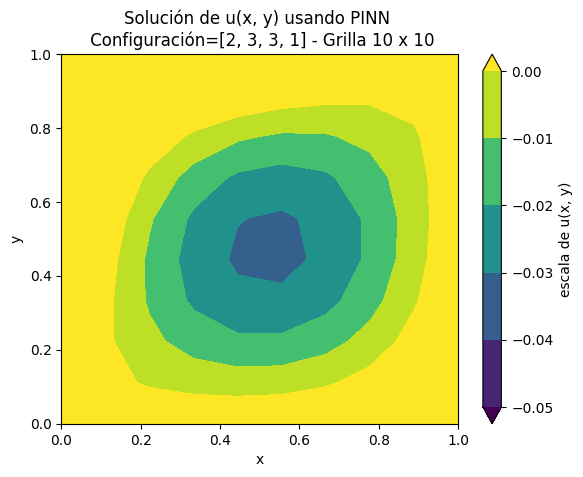

In [50]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada: (x, y), Salida: 3 neuronas
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 10x10)
        x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
        y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 10x10
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_10x10, y_10x10, u_pred_10x10, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

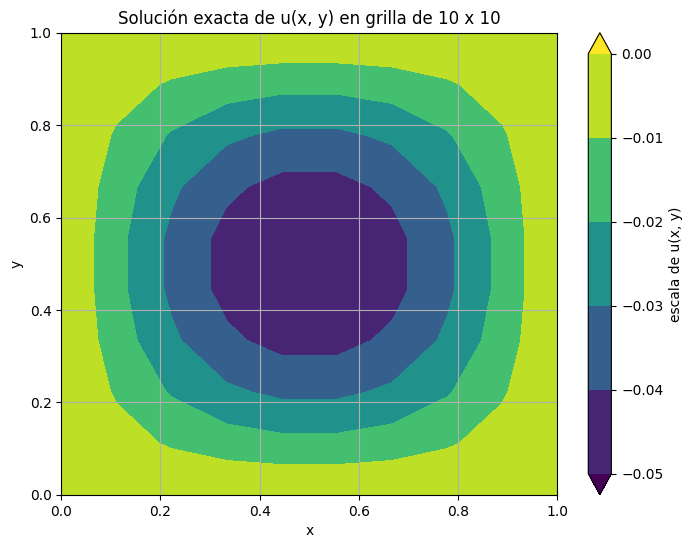

In [51]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_10x10, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

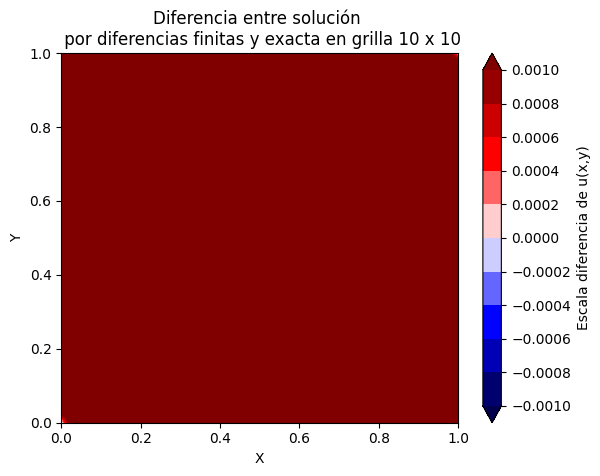

In [52]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_10x10, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.2689615488052368
Epoch 1000, Loss: 0.00849044881761074
Epoch 2000, Loss: 0.0031997940968722105
Epoch 3000, Loss: 0.0028133620508015156
Epoch 4000, Loss: 0.0023626068141311407
Epoch 5000, Loss: 0.0018621670315042138
Epoch 6000, Loss: 0.001653422717936337
Epoch 7000, Loss: 0.001525521744042635
Epoch 8000, Loss: 0.001455401536077261
Epoch 9000, Loss: 0.001396348001435399


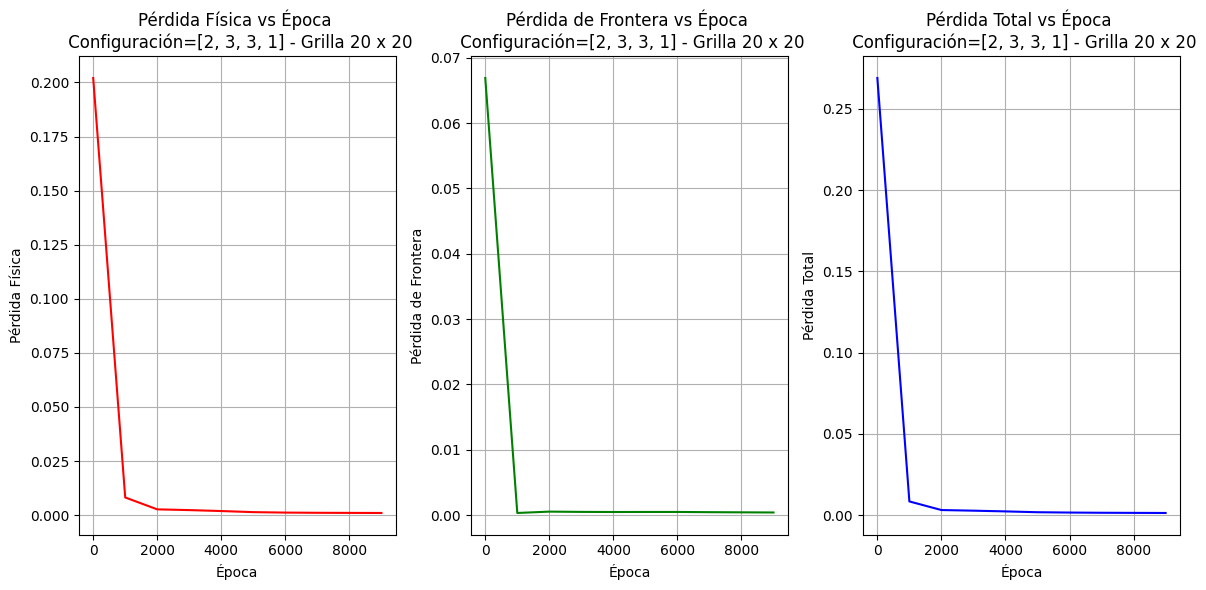

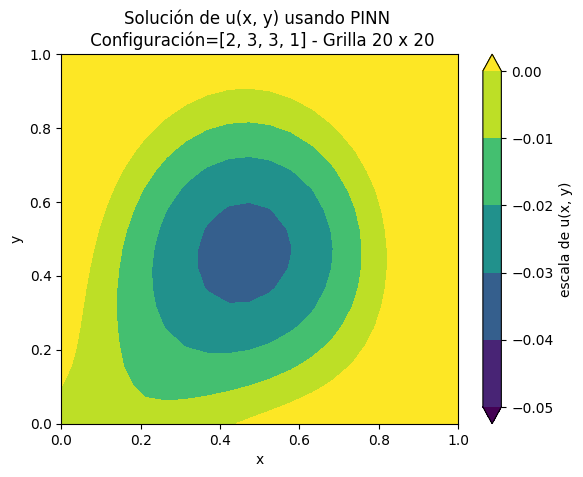

In [53]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada: (x, y), Salida: 3 neuronas
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 20x20)
        x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
        y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 20x20
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

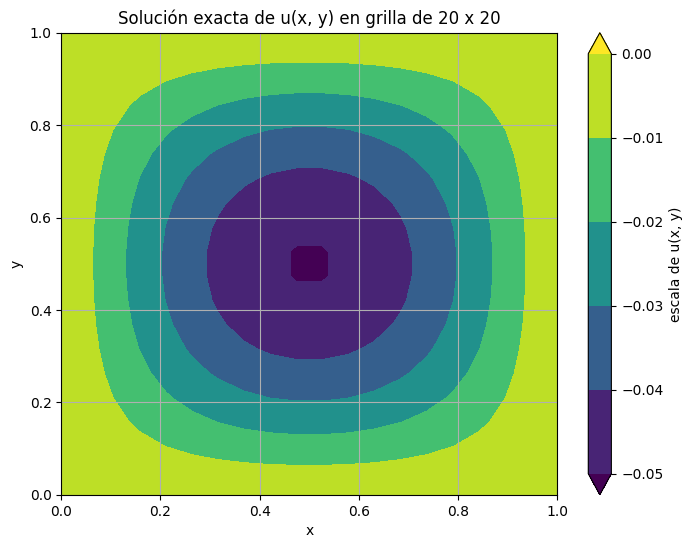

In [54]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

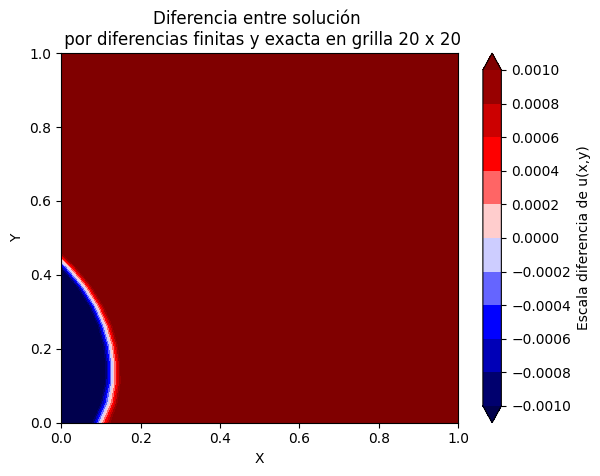

In [55]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

## B - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1]

### I - Grilla de 5 x 5:

Epoch 0, Loss: 0.291240930557251
Epoch 1000, Loss: 0.011292635463178158
Epoch 2000, Loss: 0.0031133596785366535
Epoch 3000, Loss: 0.0016991475131362677
Epoch 4000, Loss: 0.0011067441664636135
Epoch 5000, Loss: 0.0006434700917452574
Epoch 6000, Loss: 0.0004825170908588916
Epoch 7000, Loss: 0.000362736260285601
Epoch 8000, Loss: 0.0003446262562647462
Epoch 9000, Loss: 0.00033706362592056394


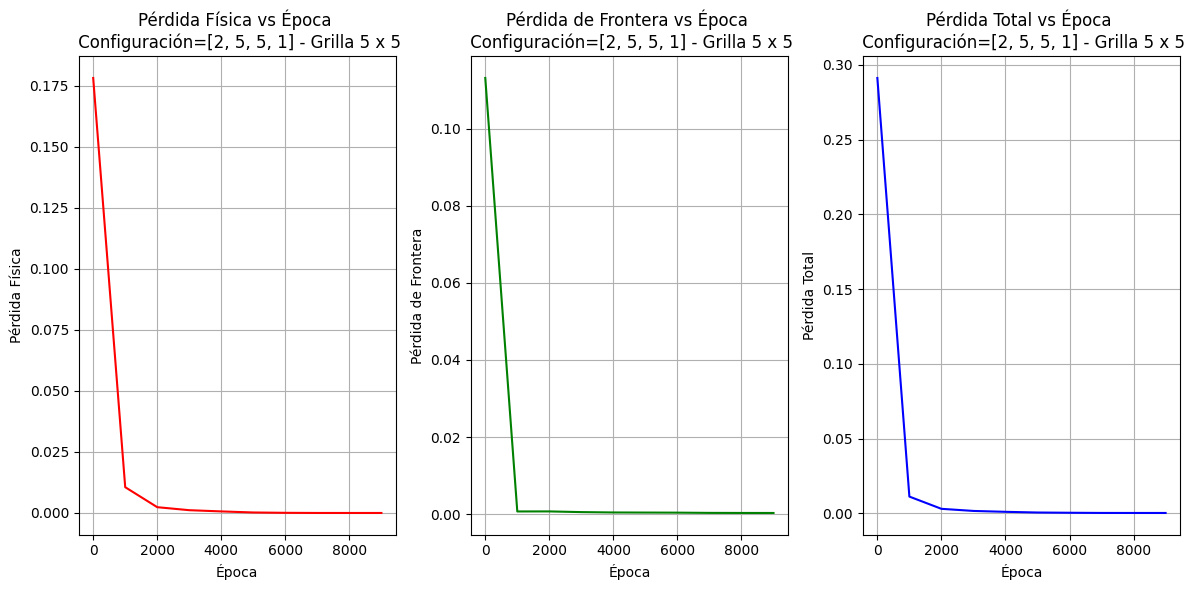

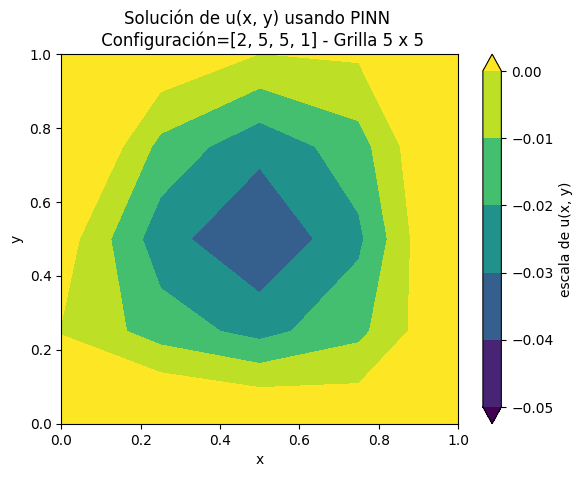

In [32]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada: (x, y), Salida: 5 neuronas
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 5x5)
        x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
        y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 5x5
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_5x5, y_5x5, u_pred_5x5, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

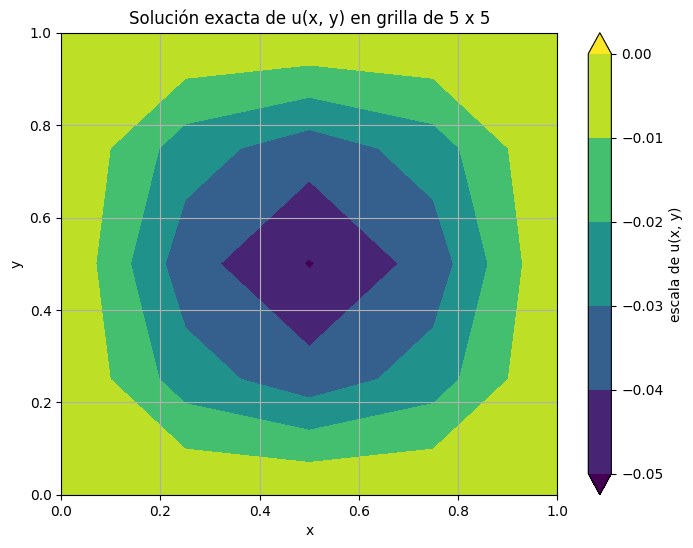

In [33]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_5x5, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

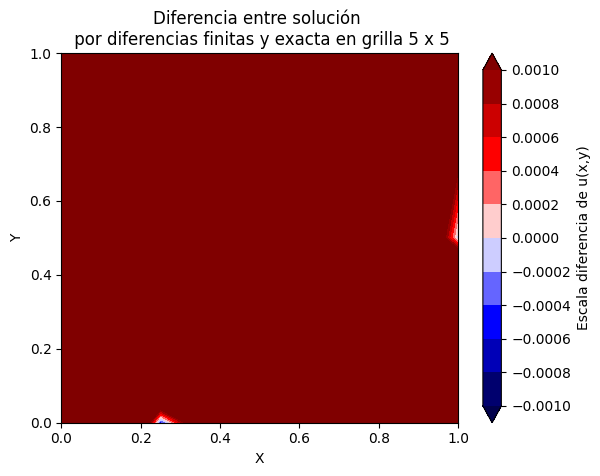

In [34]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_5x5, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.16330166161060333
Epoch 1000, Loss: 0.007156243547797203
Epoch 2000, Loss: 0.002092089969664812
Epoch 3000, Loss: 0.0009537966107018292
Epoch 4000, Loss: 0.0006122103659436107
Epoch 5000, Loss: 0.0004726749612018466
Epoch 6000, Loss: 0.0004278292472008616
Epoch 7000, Loss: 0.0003882583696395159
Epoch 8000, Loss: 0.0003549692337401211
Epoch 9000, Loss: 0.0003184437518939376


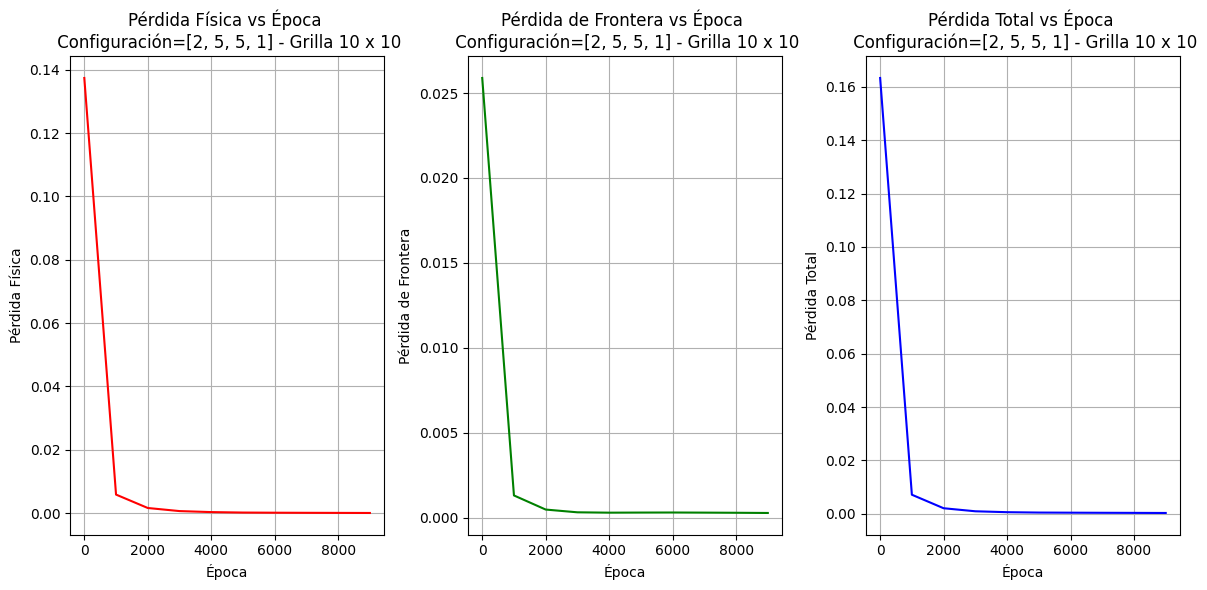

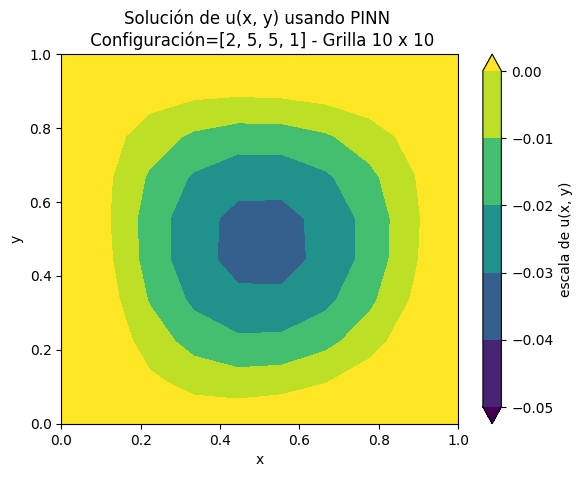

In [35]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada: (x, y), Salida: 5 neuronas
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 10x10)
        x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
        y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 10x10
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_10x10, y_10x10, u_pred_10x10, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

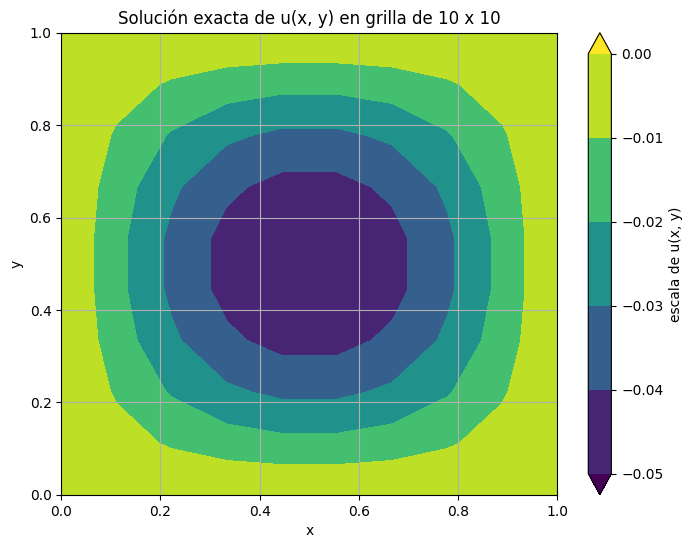

In [36]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_10x10, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

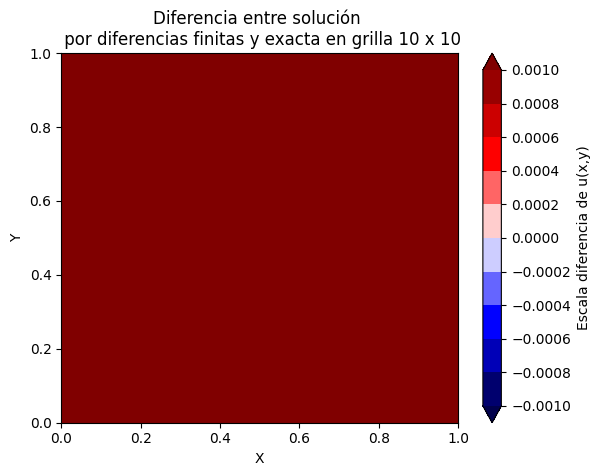

In [37]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_10x10, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.3523554801940918
Epoch 1000, Loss: 0.04903284087777138
Epoch 2000, Loss: 0.004461326636373997
Epoch 3000, Loss: 0.002696470357477665
Epoch 4000, Loss: 0.0011851283488795161
Epoch 5000, Loss: 0.0006296348292380571
Epoch 6000, Loss: 0.00044913217425346375
Epoch 7000, Loss: 0.00035183117142878473
Epoch 8000, Loss: 0.0003023867611773312
Epoch 9000, Loss: 0.0002804047253448516


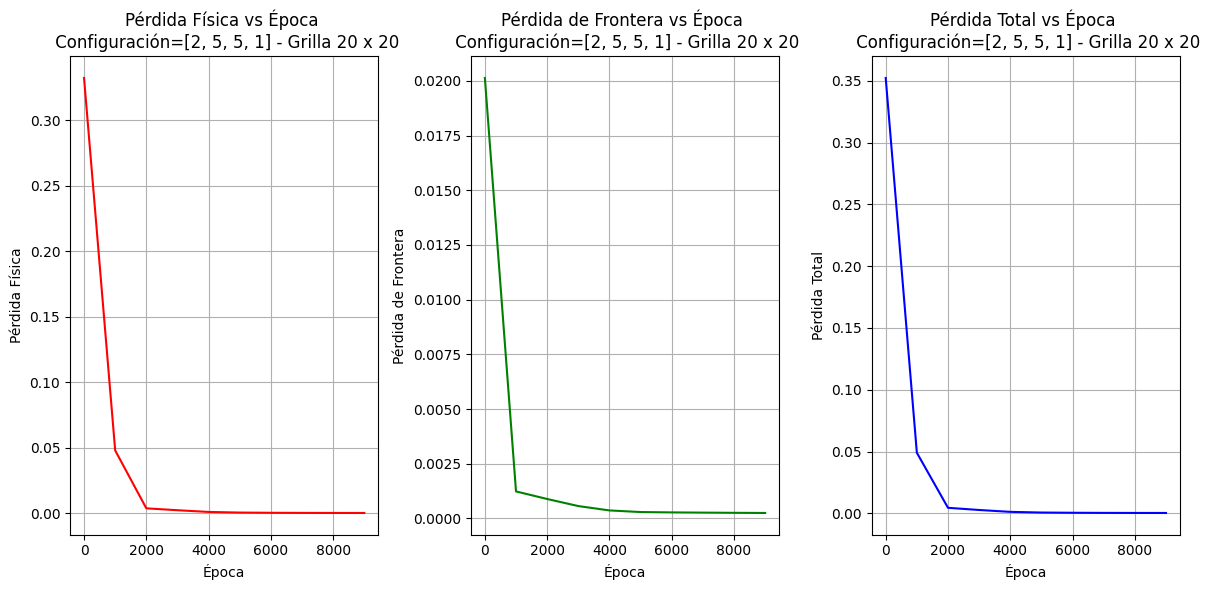

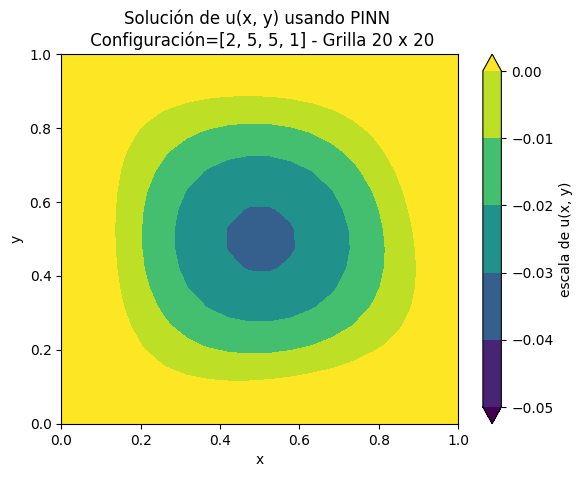

In [38]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada: (x, y), Salida: 5 neuronas
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x e y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 20x20)
        x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
        y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 20x20
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

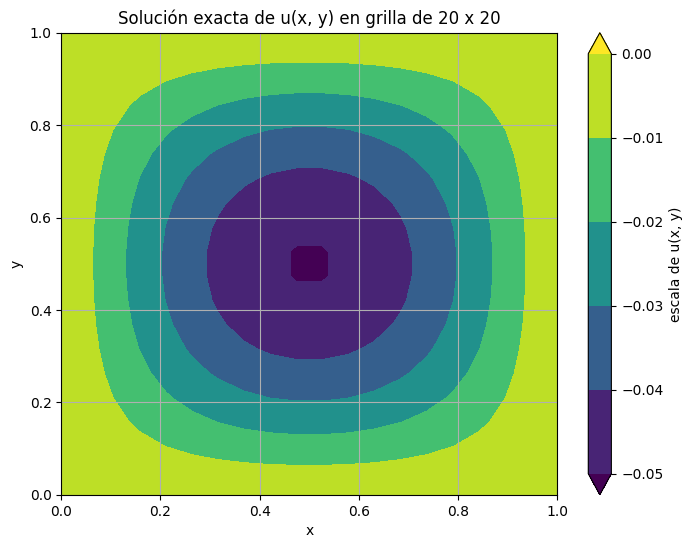

In [39]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferenicia

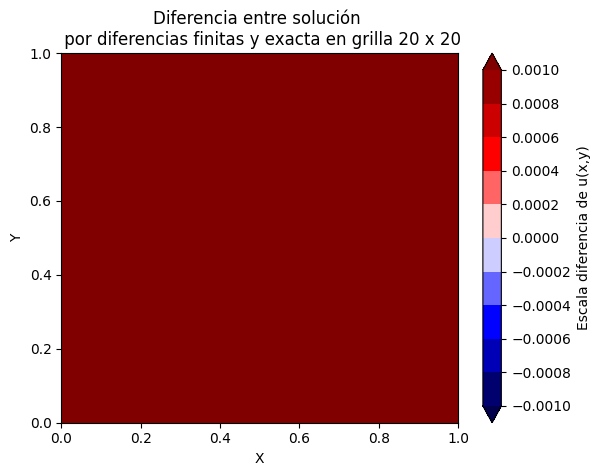

In [40]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

## C - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,10,10,1]

### I - Grilla de 5 x 5:

Epoch 0, Loss: 0.2021975815296173
Epoch 1000, Loss: 0.0012027096236124635
Epoch 2000, Loss: 0.0005029473686590791
Epoch 3000, Loss: 0.0003185074601788074
Epoch 4000, Loss: 0.00028381479205563664
Epoch 5000, Loss: 0.00027307902928441763
Epoch 6000, Loss: 0.0002684759674593806
Epoch 7000, Loss: 0.00026570254703983665
Epoch 8000, Loss: 0.0002635088167153299
Epoch 9000, Loss: 0.00026172405341640115


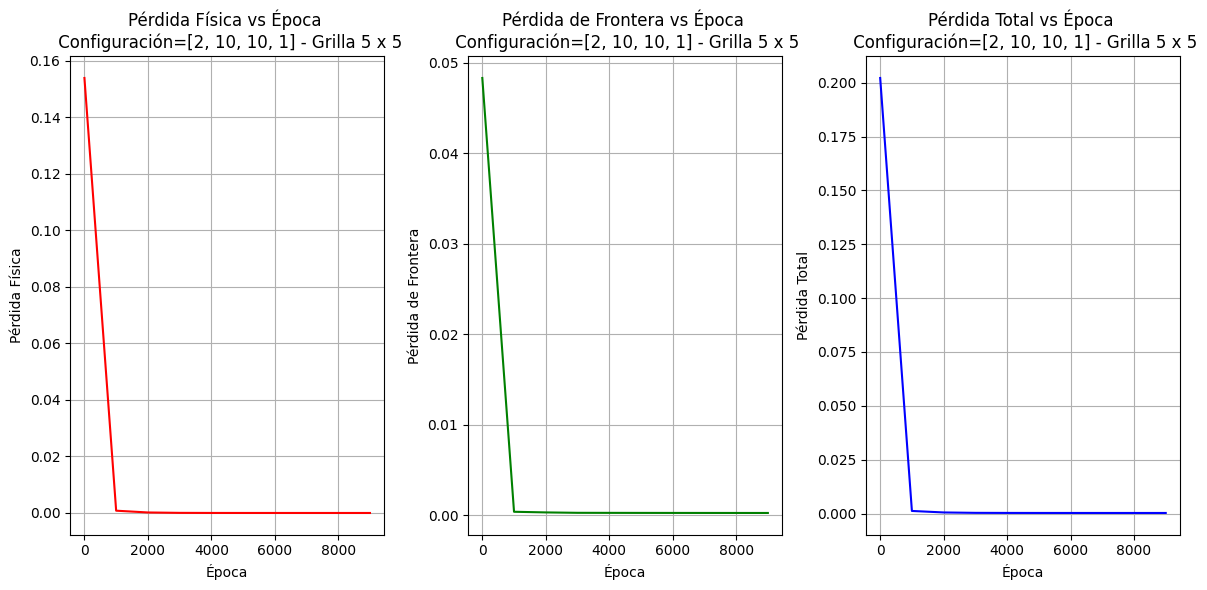

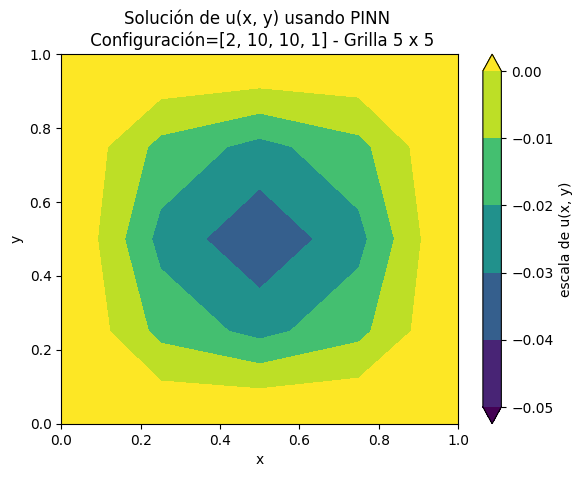

In [41]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada: (x, y), Salida: 10 neuronas
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x e y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 5x5)
        x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
        y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 5x5
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_5x5, y_5x5, u_pred_5x5, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

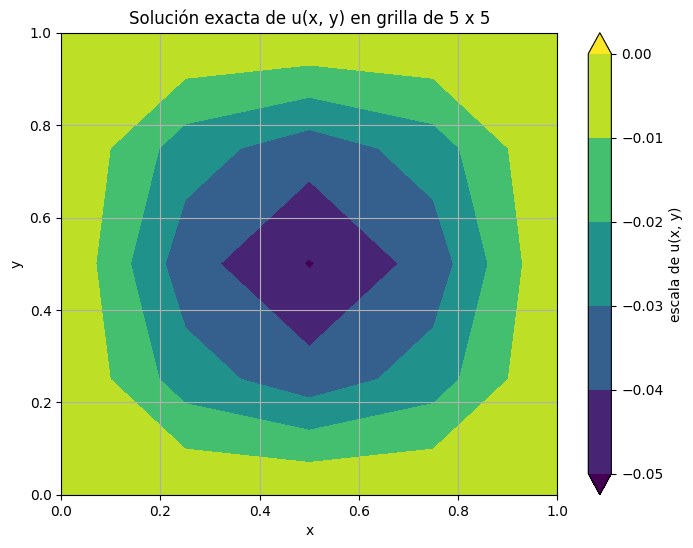

In [42]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_5x5, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

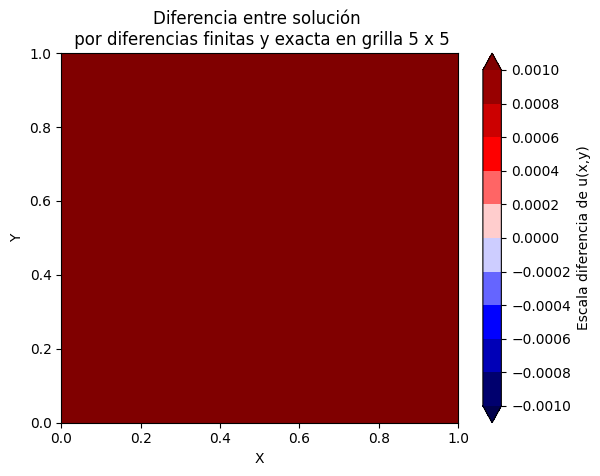

In [43]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_5x5, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.31824731826782227
Epoch 1000, Loss: 0.0020706409122794867
Epoch 2000, Loss: 0.0006548835663124919
Epoch 3000, Loss: 0.00041387719102203846
Epoch 4000, Loss: 0.0003095448773819953
Epoch 5000, Loss: 0.0002753656590357423
Epoch 6000, Loss: 0.00026300756144337356
Epoch 7000, Loss: 0.00025555433239787817
Epoch 8000, Loss: 0.00025335222017019987
Epoch 9000, Loss: 0.00024964960175566375


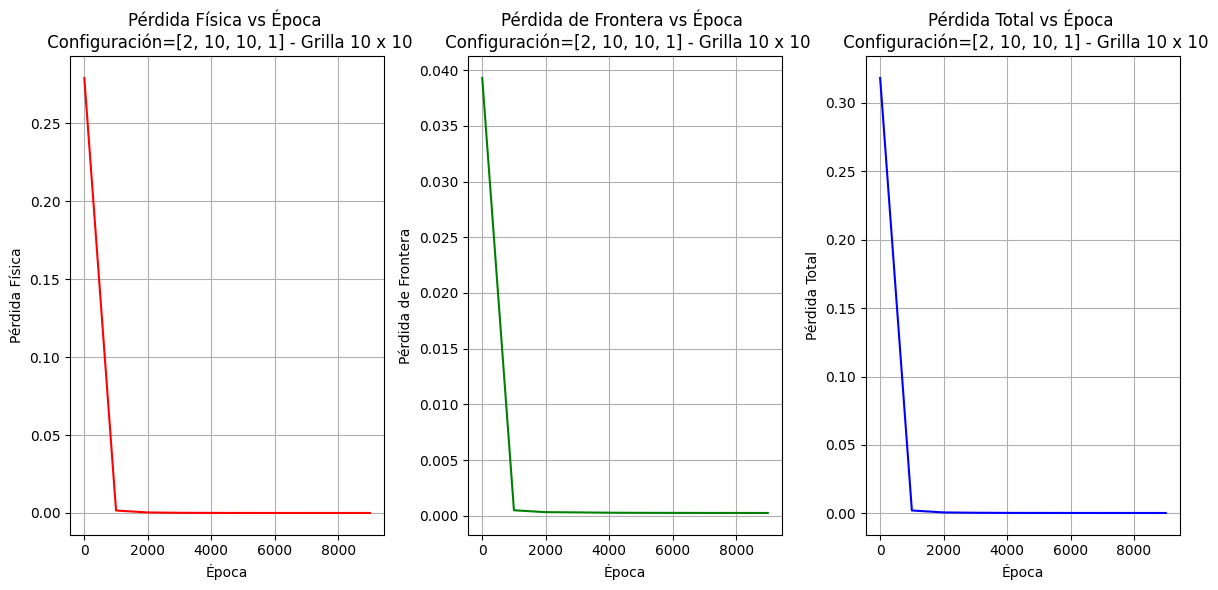

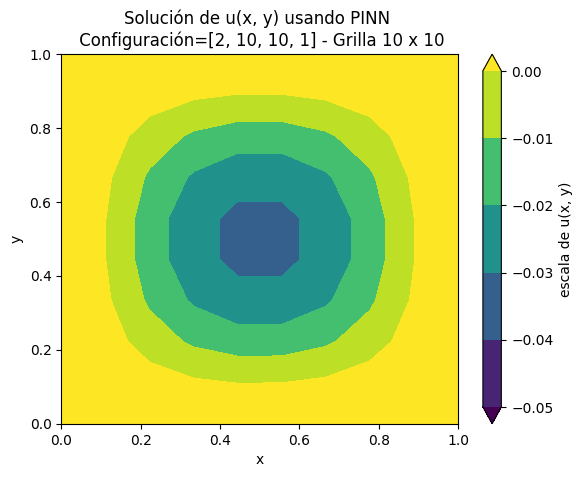

In [44]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada: (x, y), Salida: 10 neuronas
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x e y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 10x10)
        x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
        y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 10x10
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_10x10, y_10x10, u_pred_10x10, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

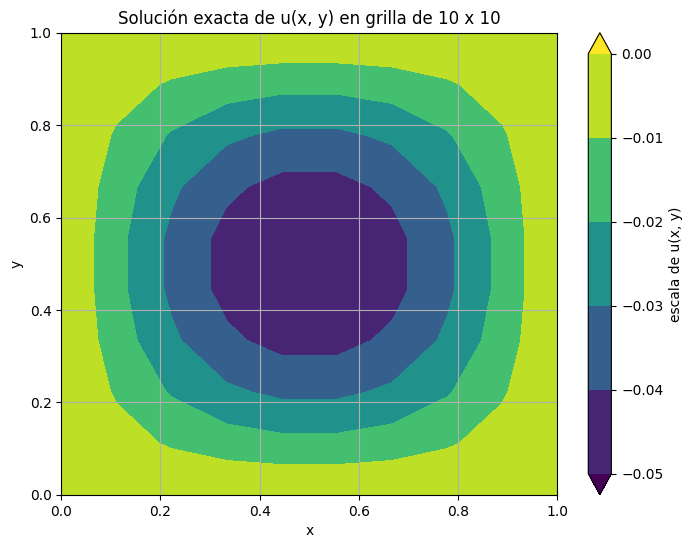

In [45]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_10x10, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

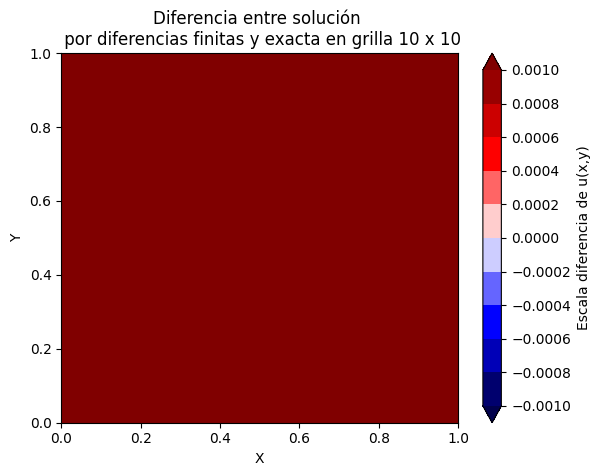

In [46]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_10x10, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.2612461447715759
Epoch 1000, Loss: 0.0011355075985193253
Epoch 2000, Loss: 0.0004908417467959225
Epoch 3000, Loss: 0.00031846959609538317
Epoch 4000, Loss: 0.0002650563546922058
Epoch 5000, Loss: 0.00025332040968351066
Epoch 6000, Loss: 0.0002658008015714586
Epoch 7000, Loss: 0.00024548853980377316
Epoch 8000, Loss: 0.00024287060659844428
Epoch 9000, Loss: 0.0002409173030173406


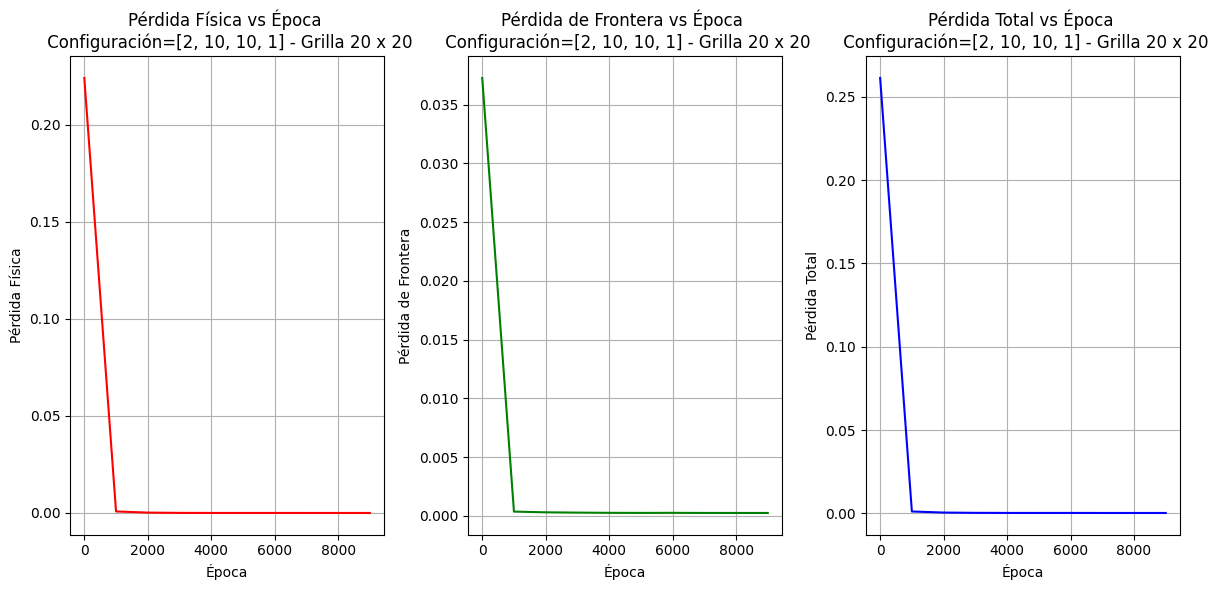

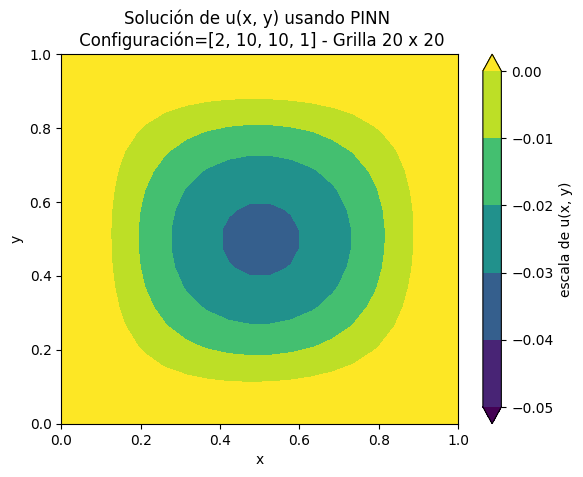

In [47]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada: (x, y), Salida: 10 neuronas
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)  # Salida: u(x, y)

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatenar x e y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Definir la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Puntos de entrenamiento (malla 20x20)
        x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
        y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
        x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
        x = x.flatten().reshape(-1, 1)
        y = y.flatten().reshape(-1, 1)

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacenar los valores de la pérdida cada 1000 épocas
        if epoch % 1000 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializar la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer)

# Crear los valores de las épocas a graficar
epochs = np.arange(0, 10000, 1000)

# Graficar las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar y visualizar los resultados
# Generar la malla de 20x20
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que x tenga requires_grad=True
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()  # Asegúrate de que y tenga requires_grad=True
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')  # Usar 'ij' para índices correctos
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Evaluar el modelo en esta malla
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convertir x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

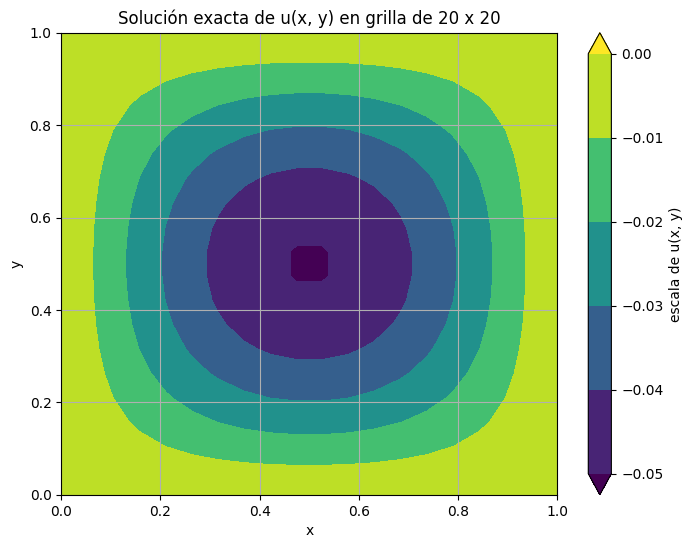

In [48]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

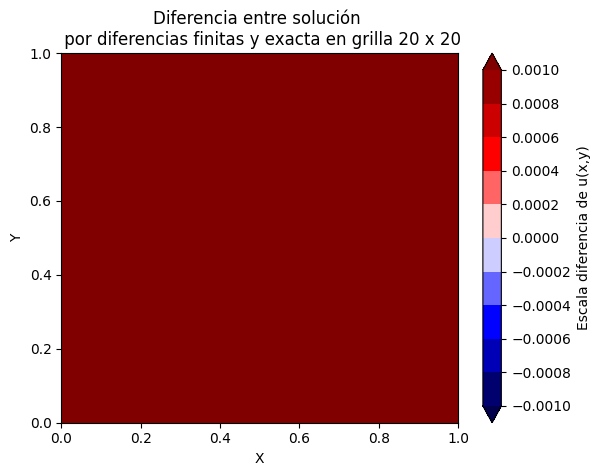

In [49]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20